# Introduction

The goal of this project is to create and train a model that can predict the quarterly returns of stocks in the U.S. The sample period is from 2000 from 2022. Macro-level data is from the Federal Reserve Bank of St. Louis. Stock-level data is from Thomson Reuters Eikon. I only consider ordinary common equity shares. 

# Library Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
import datetime

# Explorary Analysis

In [2]:
df_macro = pd.read_csv('GDP.csv')
df_macro.sort_values('DATE')

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742
...,...,...
296,2021-01-01,22038.226
297,2021-04-01,22740.959
298,2021-07-01,23202.344
299,2021-10-01,24002.815


In [3]:
df_macro['year'] = pd.DatetimeIndex(df_macro['DATE']).year
df_macro['quarter'] = pd.DatetimeIndex(df_macro['DATE']).quarter
df_macro = df_macro.drop(['DATE'], axis = 1)

In [4]:
for i in [1, 2, 5, 10, 30]: #  Treasury bond yield data
    df_yield = pd.read_csv('DGS{}.csv'.format(i))
    df_yield.columns = ['DATE', 'yield_{}y'.format(i)]
    df_yield['DATE'] = df_yield['DATE'].astype('datetime64[ns]')
    df_yield['year'] = pd.DatetimeIndex(df_yield['DATE']).year
    df_yield['quarter'] = pd.DatetimeIndex(df_yield['DATE']).quarter
    df_yield['yield_{}y'.format(i)] = pd.to_numeric(df_yield['yield_{}y'.format(i)], errors = 'coerce')
    df_yield = df_yield.sort_values('DATE').groupby(['year', 'quarter']).tail(1) # consider yields on the last day of each quarter
    df_yield = df_yield.drop(['DATE'], axis = 1)
    df_macro = pd.merge(df_macro, df_yield, on = ['year', 'quarter'])

In [5]:
df_macro.head().sort_values(['year', 'quarter'])

,GDP,year,quarter,yield_1y,yield_2y,yield_5y,yield_10y,yield_30y
0,1988.648,1977,1,5.40,6.01,6.94,7.42,7.79
1,2055.909,1977,2,5.72,6.08,6.70,7.20,7.58
2,2118.473,1977,3,6.66,6.82,7.11,7.41,7.68
3,2164.270,1977,4,6.98,7.22,7.54,7.78,8.03
4,2202.760,1978,1,7.48,7.70,7.97,8.15,8.33


In [6]:
df_macro.shape

(181, 8)

In [7]:
macro_data = {'inflation_exp': 'MICH', \
              'inflation_urban_all': 'CPIAUCSL', \
              'inflation_urban_ex_food_energy': 'CPILFESL', \
              'fed_effective_rate': 'DFF', \
              'unemployment_rate': 'UNRATE',\
              'crude_oil_price': 'WTISPLC',\
              'potential_gdp': 'NGDPPOT'}

In [8]:
for colname, filename in macro_data.items():
    df_temp = pd.read_csv('{}.csv'.format(filename))
    df_temp.columns = ['DATE', colname]
    df_temp['DATE'] = df_temp['DATE'].astype('datetime64[ns]')
    df_temp['year'] = pd.DatetimeIndex(df_temp['DATE']).year
    df_temp['quarter'] = pd.DatetimeIndex(df_temp['DATE']).quarter
    df_temp = df_temp.sort_values('DATE').groupby(['year', 'quarter']).tail(1)
    df_temp = df_temp.drop(['DATE'], axis = 1)
    df_macro = pd.merge(df_macro, df_temp, on = ['year', 'quarter'])


In [9]:
df_macro.shape

(177, 15)

In [10]:
for i in [1, 2, 5, 10, 30]: # inflation expectation by the Cleveland Fed
    dfname = 'inflation_exp_{}y'.format(i)
    dfname = pd.read_csv('EXPINF{}YR.csv'.format(i))
    dfname.columns = ['DATE', 'inflation_Exp_{}Y'.format(i)]
    dfname['DATE'] = dfname['DATE'].astype('datetime64[ns]')
    dfname['year'] = pd.DatetimeIndex(dfname['DATE']).year
    dfname['quarter'] = pd.DatetimeIndex(dfname['DATE']).quarter
    dfname = dfname.sort_values('DATE').groupby(['year', 'quarter']).tail(1)
    dfname = dfname.drop(['DATE'], axis = 1)
    df_macro = pd.merge(df_macro, dfname, on = ['year', 'quarter'])

In [11]:
df_macro.head()

,GDP,year,quarter,yield_1y,yield_2y,yield_5y,yield_10y,yield_30y,inflation_exp,inflation_urban_all,inflation_urban_ex_food_energy,fed_effective_rate,unemployment_rate,crude_oil_price,potential_gdp,inflation_Exp_1Y,inflation_Exp_2Y,inflation_Exp_5Y,inflation_Exp_10Y,inflation_Exp_30Y
0,3274.302,1982,1,14.30,14.52,14.39,14.18,13.68,4.2,94.7,93.9,16.80,9.0,28.48,3477.052316,6.387732,6.295533,6.027709,5.648130,4.655782
1,3331.972,1982,2,14.34,14.66,14.65,14.44,13.91,4.6,97.0,96.1,14.58,9.6,35.07,3549.372701,5.445233,5.838871,5.881698,5.602379,4.659658
2,3366.322,1982,3,10.26,11.23,11.69,11.73,11.79,4.5,97.7,97.2,12.17,10.1,35.63,3627.672682,6.339422,6.106970,6.002451,5.733214,4.756536
3,3402.561,1982,4,8.68,9.48,10.09,10.36,10.43,3.7,97.7,97.2,11.20,10.8,31.72,3694.173716,4.571015,4.862399,5.002224,4.862421,4.206251
4,3473.413,1983,1,9.34,9.87,10.27,10.62,10.69,1.8,98.1,98.2,10.81,10.3,28.82,3751.018696,4.062945,4.480367,4.701710,4.609992,4.050871


PB ratio: price to book value ratio
Long-term growth: long-term growth rate of EPS as prediced by professional forecastors
debt_to_ev_ratio: debt to enterprise ratio
PE ratio: price to earnings per share ratio

In [12]:
micro_data = {'pb_ratio': 'pb_ratio', \
              'long_term_growth': 'long_term_growth', \
              'debt_to_ev_ratio': 'debt_to_ev_ratio', \
             'market_cap': 'market_cap', 'pe_ratio': 'pe_ratio'} 

In [13]:
df = pd.read_csv('stock_return_3m.csv')
df.head()
df = df[['stock', 'date', 'return_3m']]
df['date'] = df['date'].astype('datetime64[ns]')
df['year'] = pd.DatetimeIndex(df['date']).year
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['return_3m'] = pd.to_numeric(df['return_3m'], errors = 'coerce')
df.loc[df['quarter'] == 1, 'year'] -= 1
df['quarter'] = df['quarter'] - 1
df.loc[df['quarter'] == 0, 'quarter'] = 4
df = df.sort_values('date').groupby(['stock', 'year', 'quarter']).tail(1)
df = df.drop(['date'], axis = 1)
df = df.sort_values(['stock', 'quarter'])

In [14]:
for filename, colname in micro_data.items():
    df_temp = pd.read_csv('{}.csv'.format(filename))
    df_temp = df_temp[['date', 'stock', colname]]
    df_temp[colname] = pd.to_numeric(df_temp[colname], errors = 'coerce')
    df_temp['date'] = df_temp['date'].astype('datetime64[ns]')
    df_temp['year'] = pd.DatetimeIndex(df_temp['date']).year
    df_temp['quarter'] = pd.DatetimeIndex(df_temp['date']).quarter
    df_temp = df_temp.sort_values('date').groupby(['quarter', 'year', 'stock']).tail(1)
    df_temp = df_temp.drop(['date'], axis = 1)
    df = pd.merge(df, df_temp, on = ['quarter', 'year', 'stock'])

In [15]:
df = pd.merge(df, df_macro, on = ['quarter', 'year'])

In [16]:
df.shape

(60768, 27)

In [17]:
df = df.sort_values(['stock', 'year', 'quarter'])

In [18]:
df[60:70]

,stock,return_3m,year,quarter,pb_ratio,long_term_growth,debt_to_ev_ratio,market_cap,pe_ratio,GDP,yield_1y,yield_2y,yield_5y,yield_10y,yield_30y,inflation_exp,inflation_urban_all,inflation_urban_ex_food_energy,fed_effective_rate,unemployment_rate,crude_oil_price,potential_gdp,inflation_Exp_1Y,inflation_Exp_2Y,inflation_Exp_5Y,inflation_Exp_10Y,inflation_Exp_30Y
10672,A,21.855273,2020.0,1.0,4.579662,7.7,10.515422,2.217723e+10,29.563401,21481.367,0.17,0.23,0.37,0.70,1.35,2.2,258.165,266.916,0.08,4.4,29.21,21832.64,0.987074,1.082918,1.121101,1.269775,1.814519
22453,A,14.224284,2020.0,2.0,5.708465,8.7,8.744965,2.728666e+10,40.549160,19477.444,0.16,0.16,0.29,0.66,1.41,3.0,257.217,266.088,0.08,11.0,38.31,21818.96,0.512757,0.802709,1.012906,1.231867,1.813111
34205,A,17.591469,2020.0,3.0,6.261887,9.4,7.239969,3.112077e+10,45.618063,21138.574,0.12,0.13,0.28,0.69,1.46,2.6,260.190,269.152,0.09,7.9,39.63,22112.54,1.582764,1.346501,1.236315,1.350999,1.857768
48000,A,7.475651,2020.0,4.0,7.440579,9.3,6.328367,3.635860e+10,51.462125,21477.597,0.10,0.13,0.36,0.93,1.65,2.5,261.564,269.984,0.09,6.7,47.02,22315.43,1.649521,1.404304,1.302465,1.417170,1.900938
11391,A,18.576240,2021.0,1.0,8.071961,10.8,6.261707,3.873924e+10,48.803894,22038.226,0.07,0.16,0.92,1.74,2.41,3.1,265.028,271.347,0.06,6.0,62.33,22644.98,1.513838,1.388169,1.365860,1.497404,1.958286
34869,A,1.474819,2021.0,3.0,9.650544,13.6,5.818652,4.768790e+10,49.076142,23202.344,0.09,0.28,0.98,1.52,2.08,4.6,274.214,280.017,0.06,4.7,71.65,23233.13,2.684137,2.007175,1.632602,1.642786,2.014232
48650,A,-17.001196,2021.0,4.0,8.946799,14.0,5.527824,4.821443e+10,40.539751,24002.815,0.39,0.73,1.26,1.52,1.90,4.8,280.126,284.770,0.07,3.9,71.71,23461.34,2.620309,2.048894,1.740795,1.758975,2.092002
8990,AA,4.270463,2018.0,1.0,1.840952,8.6,13.131701,8.370684e+09,30.196181,20143.716,NaN,NaN,NaN,NaN,NaN,2.8,249.581,256.128,1.67,4.0,62.73,20234.99,1.688744,1.772996,1.860728,1.970242,2.257159
20886,AA,-13.822526,2018.0,2.0,1.628362,11.3,13.089416,8.741050e+09,35.610112,20492.492,2.33,2.52,2.73,2.85,2.98,3.0,251.118,257.449,1.91,4.0,67.87,20503.32,1.590995,1.772140,1.924010,2.045903,2.310123
32668,AA,-34.207921,2018.0,3.0,1.499505,4.5,18.446072,7.533511e+09,41.815020,20659.102,2.59,2.81,2.94,3.05,3.19,2.7,252.239,258.505,2.18,3.7,70.23,20682.68,2.410015,2.206002,2.103109,2.136153,2.340414


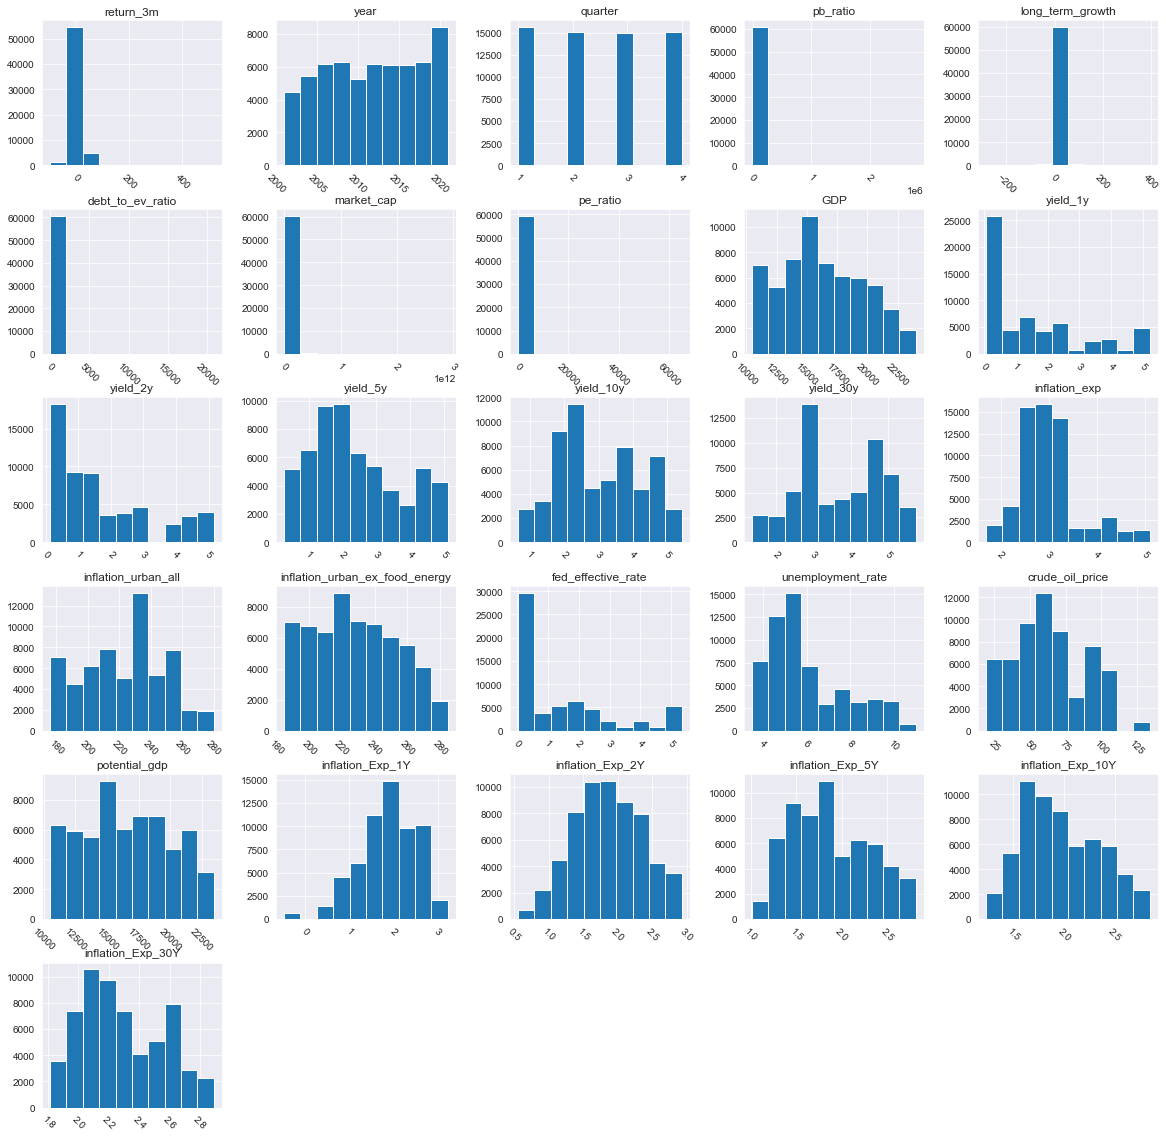

In [19]:
df.hist(figsize = (20, 20), xrot = -45)
plt.show()

In [20]:
df.describe()

,return_3m,year,quarter,pb_ratio,long_term_growth,debt_to_ev_ratio,market_cap,pe_ratio,GDP,yield_1y,yield_2y,yield_5y,yield_10y,yield_30y,inflation_exp,inflation_urban_all,inflation_urban_ex_food_energy,fed_effective_rate,unemployment_rate,crude_oil_price,potential_gdp,inflation_Exp_1Y,inflation_Exp_2Y,inflation_Exp_5Y,inflation_Exp_10Y,inflation_Exp_30Y
count,60768.000000,60768.000000,60768.000000,6.076700e+04,60768.000000,60755.000000,6.076800e+04,59461.000000,60768.000000,58517.000000,58517.000000,58517.000000,58517.000000,58517.000000,60768.000000,60768.000000,60768.000000,60768.000000,60768.000000,60768.000000,60768.000000,60768.000000,60768.000000,60768.000000,60768.000000,60768.000000
mean,3.571368,2011.238547,2.485338,4.928740e+01,13.504497,24.025858,1.992141e+10,43.097762,16290.767674,1.508103,1.714208,2.365195,3.016907,3.683895,3.001761,223.642872,228.640461,1.411636,5.967634,63.827310,16573.903997,1.883698,1.850269,1.872270,1.972780,2.289875
std,18.883694,5.877614,1.122002,1.129986e+04,12.629475,88.136956,6.320553e+10,447.601791,3415.429543,1.540791,1.466446,1.303823,1.203594,1.136131,0.624936,25.925145,25.699882,1.637741,1.829860,24.826724,3482.981381,0.672985,0.507640,0.433792,0.387208,0.269088
min,-97.976190,2001.000000,1.000000,-1.003685e+04,-284.800000,0.000000,1.275183e+05,0.020666,10470.231000,0.070000,0.130000,0.280000,0.660000,1.350000,1.700000,176.100000,184.700000,0.040000,3.500000,19.330000,10494.099700,-0.480678,0.555476,1.012906,1.231867,1.813111
25%,-5.992586,2006.000000,1.000000,1.520062e+00,8.330000,6.889079,1.474006e+09,14.169679,13870.188000,0.210000,0.560000,1.390000,2.060000,2.820000,2.700000,202.800000,207.200000,0.090000,4.600000,45.480000,13792.048520,1.503148,1.503438,1.537020,1.648906,2.091541
50%,3.361415,2011.000000,2.000000,2.481791e+00,12.133540,18.688256,4.483774e+09,19.815420,15842.267000,1.030000,1.270000,1.930000,2.730000,3.560000,3.000000,227.223000,227.405000,0.820000,5.400000,60.560000,16382.923110,1.933676,1.846777,1.812388,1.894122,2.212204
75%,12.849222,2016.000000,3.000000,4.241028e+00,16.500000,35.080108,1.489699e+10,29.299151,18968.041000,2.360000,2.630000,3.340000,3.990000,4.770000,3.200000,242.637000,249.920000,2.180000,7.200000,82.410000,19307.290000,2.341925,2.221316,2.241176,2.327409,2.553916
max,519.047619,2021.000000,4.000000,2.785410e+06,396.478000,20796.686330,2.901640e+12,65000.000000,24002.815000,5.210000,5.160000,5.100000,5.420000,5.750000,5.100000,280.126000,284.770000,5.340000,11.000000,133.930000,23461.340000,3.227172,2.930084,2.813237,2.845305,2.891442


Price to book-value ratio cannot become negative. So those observations are suspicious. 

In [21]:
len(df[df['pb_ratio'] <= 0])

1584

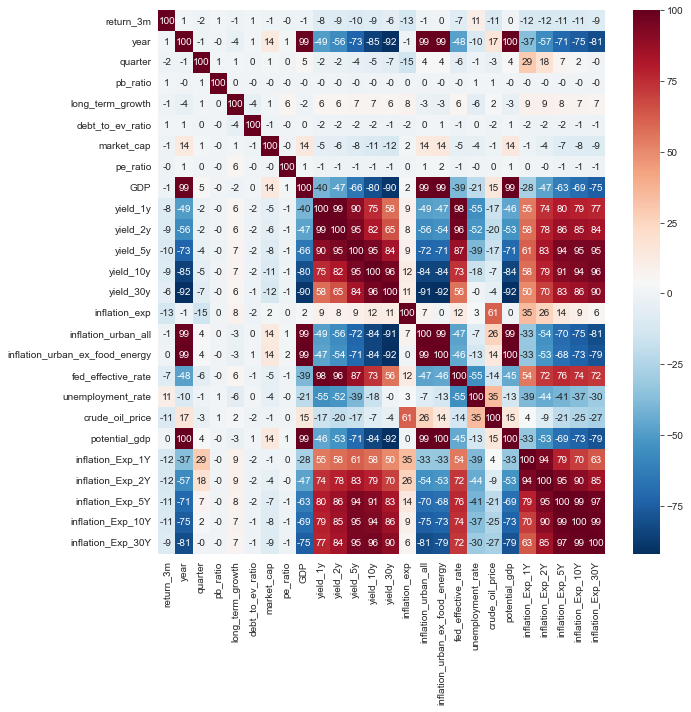

In [22]:
correlations = df.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(correlations*100, annot = True, fmt = '.0f', cmap = 'RdBu_r')
plt.show()

In [23]:
df.dtypes

stock                              object
return_3m                         float64
year                              float64
quarter                           float64
pb_ratio                          float64
long_term_growth                  float64
debt_to_ev_ratio                  float64
market_cap                        float64
pe_ratio                          float64
GDP                               float64
yield_1y                          float64
yield_2y                          float64
yield_5y                          float64
yield_10y                         float64
yield_30y                         float64
inflation_exp                     float64
inflation_urban_all               float64
inflation_urban_ex_food_energy    float64
fed_effective_rate                float64
unemployment_rate                 float64
crude_oil_price                   float64
potential_gdp                     float64
inflation_Exp_1Y                  float64
inflation_Exp_2Y                  

In [24]:
df.to_csv('ready_to_clean_data.csv', index = None)

# Data Cleaning

In [25]:
df = pd.read_csv('ready_to_clean_data.csv')

In [26]:
df = df.drop_duplicates()

In [27]:
df.isnull().sum()

stock                                0
return_3m                            0
year                                 0
quarter                              0
pb_ratio                             1
long_term_growth                     0
debt_to_ev_ratio                    13
market_cap                           0
pe_ratio                          1307
GDP                                  0
yield_1y                          2251
yield_2y                          2251
yield_5y                          2251
yield_10y                         2251
yield_30y                         2251
inflation_exp                        0
inflation_urban_all                  0
inflation_urban_ex_food_energy       0
fed_effective_rate                   0
unemployment_rate                    0
crude_oil_price                      0
potential_gdp                        0
inflation_Exp_1Y                     0
inflation_Exp_2Y                     0
inflation_Exp_5Y                     0
inflation_Exp_10Y        

P/E ratio cannot be negative. So drop stocks with negative PE ratios. 

In [28]:
df = df[~df['return_3m'].isnull()]

In [29]:
df = df[~df['yield_1y'].isnull()]

In [30]:
df = df[df['pe_ratio'].isnull() | (df['pe_ratio'] >= 0)]

In [31]:
df = df[df['pb_ratio'].isnull() | (df['pb_ratio'] >= 0)]

In [32]:
df = df[df['debt_to_ev_ratio'].isnull() | (df['debt_to_ev_ratio'] >= 0)]

In [33]:
df = df[df.long_term_growth >= -100 | df.long_term_growth.isnull()]

In [34]:
df.isnull().sum()

stock                                0
return_3m                            0
year                                 0
quarter                              0
pb_ratio                             1
long_term_growth                     0
debt_to_ev_ratio                     9
market_cap                           0
pe_ratio                          1042
GDP                                  0
yield_1y                             0
yield_2y                             0
yield_5y                             0
yield_10y                            0
yield_30y                            0
inflation_exp                        0
inflation_urban_all                  0
inflation_urban_ex_food_energy       0
fed_effective_rate                   0
unemployment_rate                    0
crude_oil_price                      0
potential_gdp                        0
inflation_Exp_1Y                     0
inflation_Exp_2Y                     0
inflation_Exp_5Y                     0
inflation_Exp_10Y        

In [35]:
df['contains_na'] = df['debt_to_ev_ratio'].isnull() | df['pe_ratio'].isnull()

In [36]:
incomplete_stock_list = df.groupby('stock')['contains_na', 'stock'].sum()

C:\Users\rohhe\AppData\Local\Temp\ipykernel_2144\2445570019.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  incomplete_stock_list = df.groupby('stock')['contains_na', 'stock'].sum()


In [37]:
incomplete_stock_list['problematic'] = incomplete_stock_list['contains_na'] > 0

In [38]:
df = pd.merge(df, incomplete_stock_list, on = 'stock')

In [39]:
len(df)

54838

In [40]:
df = df[df.problematic == False]

In [41]:
len(df)

30633

In [42]:
df.isnull().sum()

stock                             0
return_3m                         0
year                              0
quarter                           0
pb_ratio                          0
long_term_growth                  0
debt_to_ev_ratio                  0
market_cap                        0
pe_ratio                          0
GDP                               0
yield_1y                          0
yield_2y                          0
yield_5y                          0
yield_10y                         0
yield_30y                         0
inflation_exp                     0
inflation_urban_all               0
inflation_urban_ex_food_energy    0
fed_effective_rate                0
unemployment_rate                 0
crude_oil_price                   0
potential_gdp                     0
inflation_Exp_1Y                  0
inflation_Exp_2Y                  0
inflation_Exp_5Y                  0
inflation_Exp_10Y                 0
inflation_Exp_30Y                 0
contains_na_x               

No missing values in the data. Now check the distirbution of each variable and see if there are suspicious outliers. 

Variable :  return_3m


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


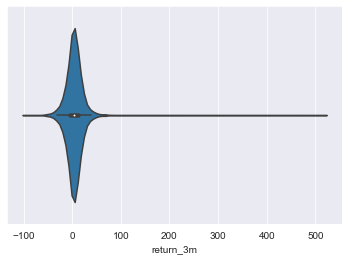

Variable :  year


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


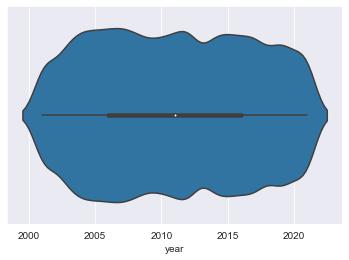

Variable :  quarter


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


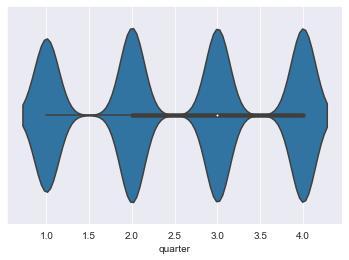

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  pb_ratio


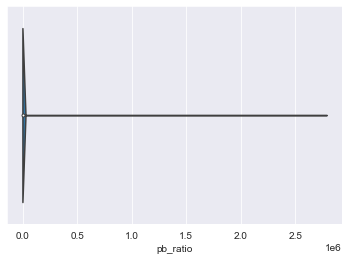

Variable :  long_term_growth


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


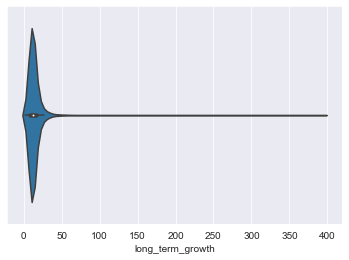

Variable :  debt_to_ev_ratio


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


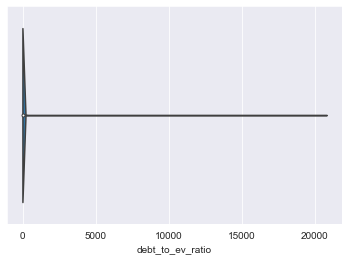

Variable :  market_cap


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


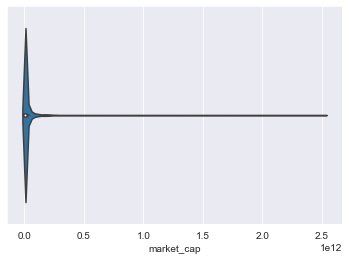

Variable :  pe_ratio


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


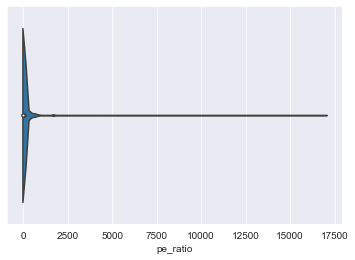

Variable :  GDP


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


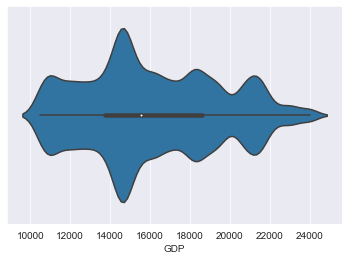

Variable :  yield_1y


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


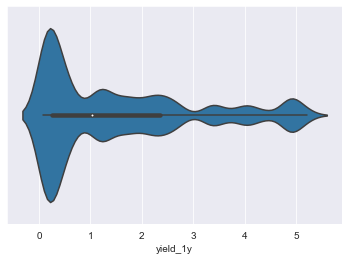

Variable :  yield_2y


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


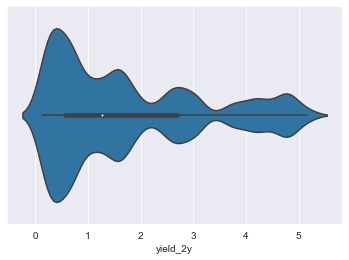

Variable :  yield_5y


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


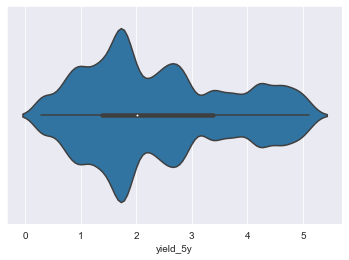

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  yield_10y


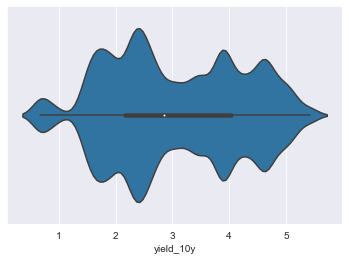

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  yield_30y


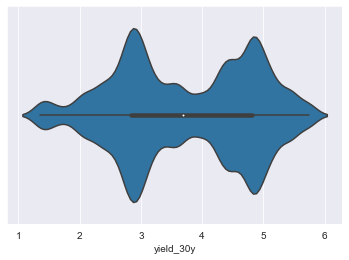

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  inflation_exp


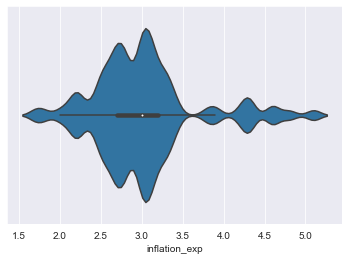

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  inflation_urban_all


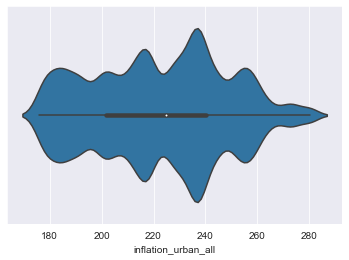

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  inflation_urban_ex_food_energy


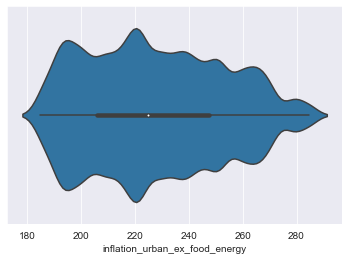

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  fed_effective_rate


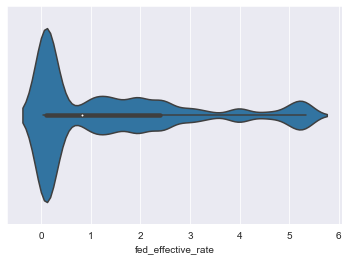

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  unemployment_rate


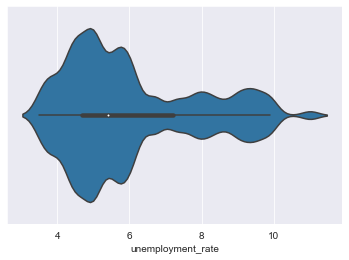

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  crude_oil_price


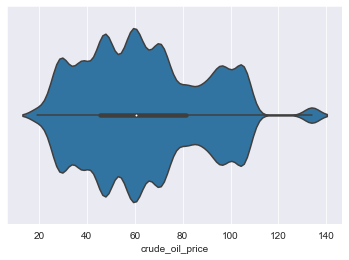

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  potential_gdp


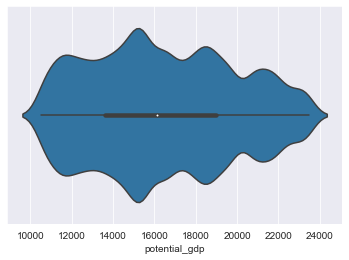

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  inflation_Exp_1Y


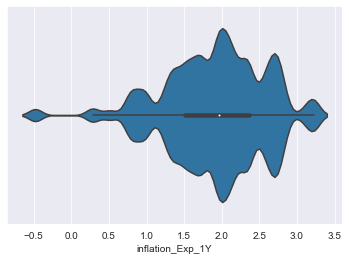

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  inflation_Exp_2Y


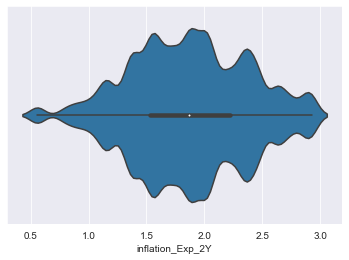

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  inflation_Exp_5Y


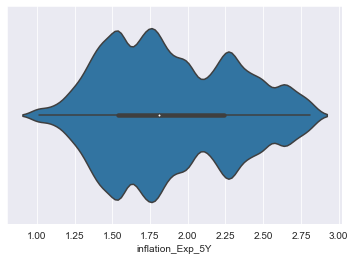

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  inflation_Exp_10Y


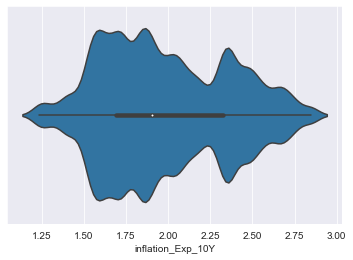

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  inflation_Exp_30Y


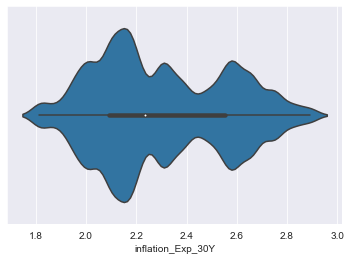

C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Variable :  contains_na_x


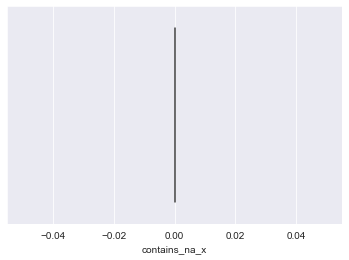

Variable :  contains_na_y


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


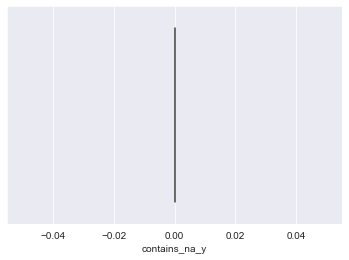

Variable :  problematic


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


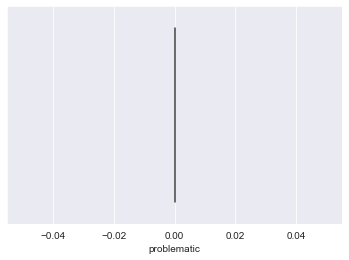

In [43]:
for col in df.columns:
    if col != 'stock':
        print('Variable : ', col)
        sns.violinplot(col, data = df)
        plt.show()

In [44]:
df.head()

,stock,return_3m,year,quarter,pb_ratio,long_term_growth,debt_to_ev_ratio,market_cap,pe_ratio,GDP,yield_1y,yield_2y,yield_5y,yield_10y,yield_30y,inflation_exp,inflation_urban_all,inflation_urban_ex_food_energy,fed_effective_rate,unemployment_rate,crude_oil_price,potential_gdp,inflation_Exp_1Y,inflation_Exp_2Y,inflation_Exp_5Y,inflation_Exp_10Y,inflation_Exp_30Y,contains_na_x,contains_na_y,problematic
63,AA,-13.822526,2018.0,2.0,1.628362,11.30,13.089416,8.741050e+09,35.610112,20492.492,2.33,2.52,2.73,2.85,2.98,3.0,251.118,257.449,1.91,4.0,67.87,20503.32000,1.590995,1.772140,1.924010,2.045903,2.310123,False,0,False
64,AA,-34.207921,2018.0,3.0,1.499505,4.50,18.446072,7.533511e+09,41.815020,20659.102,2.59,2.81,2.94,3.05,3.19,2.7,252.239,258.505,2.18,3.7,70.23,20682.68000,2.410015,2.206002,2.103109,2.136153,2.340414,False,0,False
65,AA,5.944319,2018.0,4.0,0.950347,4.00,23.300936,4.957012e+09,80.638311,20813.325,2.63,2.48,2.51,2.69,3.02,2.7,252.551,259.934,2.40,3.9,49.52,20881.05000,1.981070,1.995989,2.019533,2.091349,2.323323,False,0,False
66,AAL.O,-25.395774,2015.0,1.0,18.215095,23.20,37.980535,3.676918e+10,13.417155,17991.348,0.26,0.56,1.37,1.94,2.54,3.0,235.976,240.755,0.06,5.4,47.82,18297.43359,0.798439,1.190572,1.495196,1.703487,2.115891,False,0,False
67,AAL.O,-2.536477,2015.0,2.0,10.024215,20.05,50.932689,2.766692e+10,8.717757,18193.707,0.28,0.64,1.63,2.35,3.11,2.7,237.657,242.064,0.08,5.3,59.82,18481.76535,1.775055,1.695114,1.711298,1.824036,2.164157,False,0,False


In [45]:
df.sort_values(by = "pb_ratio", ascending = False)

,stock,return_3m,year,quarter,pb_ratio,long_term_growth,debt_to_ev_ratio,market_cap,pe_ratio,GDP,yield_1y,yield_2y,yield_5y,yield_10y,yield_30y,inflation_exp,inflation_urban_all,inflation_urban_ex_food_energy,fed_effective_rate,unemployment_rate,crude_oil_price,potential_gdp,inflation_Exp_1Y,inflation_Exp_2Y,inflation_Exp_5Y,inflation_Exp_10Y,inflation_Exp_30Y,contains_na_x,contains_na_y,problematic
48418,TRIP.O,41.491472,2011.0,4.0,2.785410e+06,17.50000,0.000000,3.365861e+09,21.560124,15842.267,0.12,0.25,0.83,1.89,2.89,3.1,227.223,227.405,0.04,8.5,98.57,16382.92311,1.711663,1.550482,1.522191,1.642213,2.048818,False,0,False
43770,SHLS.O,-29.876543,2021.0,4.0,4.741895e+03,34.67900,5.893713,4.054320e+09,540.600667,24002.815,0.39,0.73,1.26,1.52,1.90,4.8,280.126,284.770,0.07,3.9,71.71,23461.34000,2.620309,2.048894,1.740795,1.758975,2.092002,False,0,False
12147,CPB,-10.524073,2002.0,4.0,3.207567e+03,6.30000,28.943889,9.632532e+09,17.666940,11061.433,1.32,1.61,2.78,3.83,5.03,2.5,181.800,192.100,1.16,6.0,29.42,11360.39761,1.951158,2.045936,2.199139,2.327409,2.572735,False,0,False
53800,WU,-0.202265,2008.0,2.0,2.472000e+03,13.25000,17.087861,1.829213e+10,21.732823,14865.701,2.36,2.63,3.34,3.99,4.53,5.1,217.463,215.424,2.47,5.6,133.93,14821.57825,2.728512,2.436477,2.283534,2.303466,2.517528,False,0,False
9326,CCK,-10.530547,2014.0,2.0,2.298942e+03,9.80000,37.347026,6.896827e+09,22.717934,17462.703,0.11,0.47,1.62,2.53,3.34,3.1,237.231,237.837,0.09,6.1,105.79,17954.72347,1.526546,1.572693,1.684508,1.830090,2.178744,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34107,NC,0.417226,2012.0,1.0,1.230693e-01,21.70000,18.857727,7.905847e+08,0.895556,16068.824,0.19,0.33,1.04,2.23,3.35,3.9,228.807,228.478,0.09,8.2,106.19,16553.78162,1.362054,1.357174,1.425537,1.580148,2.019441,False,0,False
25856,INVE.O,-32.631579,2001.0,1.0,1.162000e-01,40.00000,0.286347,2.318216e+08,3.185479,10470.231,4.09,4.18,4.62,4.93,5.46,2.8,176.100,184.700,5.29,4.3,27.24,10494.09970,2.142245,2.355145,2.443328,2.498687,2.661808,False,0,False
34102,NC,19.416383,2010.0,1.0,1.128396e-01,23.50000,62.721915,4.990818e+08,5.266400,14764.611,0.41,1.02,2.55,3.84,4.72,2.7,217.353,220.783,0.09,9.9,81.24,15445.96164,1.970139,1.846777,1.881111,2.006760,2.353377,False,0,False
16568,EHC,467.307692,2003.0,2.0,5.186828e-02,11.50000,100.712425,2.061421e+08,0.731860,11312.766,1.09,1.32,2.46,3.54,4.81,2.1,183.100,193.000,1.45,6.3,30.72,11586.90069,2.284731,2.019628,1.909655,1.978814,2.313671,False,0,False


In [46]:
df.to_csv('data_cleaned.csv', index = None)

## Feature Engineering

In [47]:
df_cleaned = pd.read_csv('data_cleaned.csv')
df_cleaned['yield_spread'] = df_cleaned['yield_10y'] - df_cleaned['yield_2y']
df_cleaned['gdp_gap'] = (df_cleaned['GDP'] - df_cleaned['potential_gdp'])/df_cleaned['potential_gdp'].astype("float")

In [48]:
df_time_series = df_cleaned.groupby(['year', 'quarter']).mean()

In [49]:
df_time_series.head()

return_3m  pb_ratio  long_term_growth  debt_to_ev_ratio  \
year   quarter                                                            
2001.0 1.0      12.997214  3.865882         15.527482         21.981270   
       2.0     -10.207513  3.839058         14.600254         24.221387   
       3.0      19.216038  4.186212         14.471431         24.919493   
       4.0       7.649642  4.013016         14.514070         23.387138   
2002.0 2.0     -13.469169  4.148375         14.253744         21.629029   

                  market_cap   pe_ratio        GDP  yield_1y  yield_2y  \
year   quarter                                                           
2001.0 1.0      1.480686e+10  23.311434  10470.231      4.09      4.18   
       2.0      1.287177e+10  22.648094  10599.000      3.72      4.25   
       3.0      1.328995e+10  19.538218  10598.020      2.49      2.86   
       4.0      1.496919e+10  50.889172  10660.465      2.17      3.07   
2002.0 2.0      1.261762e+10  47.086569  10887.460      2.06      2.90   

                yield_5y  yield_10y  yield_30y  inflation_exp  \
year   quarter                                                  
2001.0 1.0          4.62       4.93       5.46            2.8   
       2.0          4.97       5.42       5.75            3.0   
       3.0          3.93       4.60       5.42            2.8   
       4.0          4.38       5.07       5.48            1.8   
2002.0 2.0          4.09       4.86       5.70            2.7   

                inflation_urban_all  inflation_urban_ex_food_energy  \
year   quarter                                                        
2001.0 1.0                    176.1                           184.7   
       2.0                    177.7                           186.0   
       3.0                    178.1                           187.1   
       4.0                    177.4                           188.4   
2002.0 2.0                    179.6                           190.2   

                fed_effective_rate  unemployment_rate  crude_oil_price  \
year   quarter                                                           
2001.0 1.0                    5.29                4.3            27.24   
       2.0                    3.95                4.5            27.60   
       3.0                    2.75                5.0            25.88   
       4.0                    1.52                5.7            19.33   
2002.0 2.0                    1.73                5.8            25.52   

                potential_gdp  inflation_Exp_1Y  inflation_Exp_2Y  \
year   quarter                                                      
2001.0 1.0        10494.09970          2.142245          2.355145   
       2.0        10644.10864          2.751184          2.769259   
       3.0        10769.24684          3.115226          2.888723   
       4.0        10882.90509          2.731375          2.611279   
2002.0 2.0        11104.69167          2.341925          2.470188   

                inflation_Exp_5Y  inflation_Exp_10Y  inflation_Exp_30Y  \
year   quarter                                                           
2001.0 1.0              2.443328           2.498687           2.661808   
       2.0              2.813237           2.845305           2.891442   
       3.0              2.763910           2.749027           2.809119   
       4.0              2.598191           2.639346           2.754605   
2002.0 2.0              2.636385           2.730369           2.835529   

                contains_na_x  contains_na_y  problematic  yield_spread  \
year   quarter                                                            
2001.0 1.0                0.0            0.0          0.0          0.75   
       2.0                0.0            0.0          0.0          1.17   
       3.0                0.0            0.0          0.0          1.74   
       4.0                0.0            0.0          0.0          2.00   
2002.0 2.0                0.0            0.0 

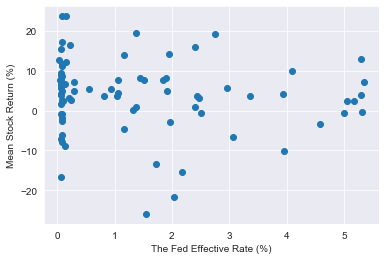

In [50]:
plt.scatter(df_time_series.fed_effective_rate, df_time_series.return_3m)
plt.xlabel('The Fed Effective Rate (%)')
plt.ylabel('Mean Stock Return (%)')
plt.show()

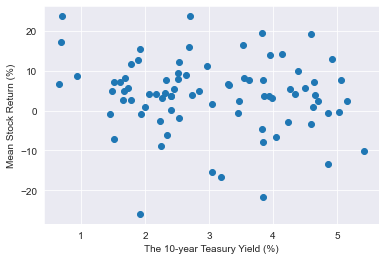

In [51]:
plt.scatter(df_time_series.yield_10y, df_time_series.return_3m)
plt.xlabel('The 10-year Teasury Yield (%)')
plt.ylabel('Mean Stock Return (%)')
plt.show()

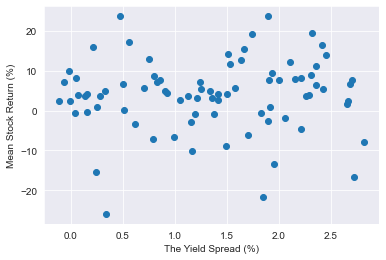

In [52]:
plt.scatter(df_time_series['yield_spread'], df_time_series['return_3m'])
plt.xlabel('The Yield Spread (%)')
plt.ylabel('Mean Stock Return (%)')
plt.show()

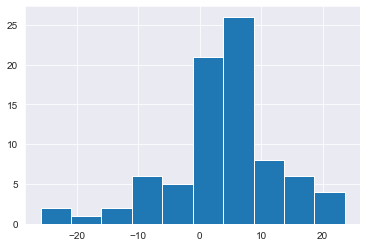

In [53]:
plt.hist(df_time_series['return_3m'])
plt.show()

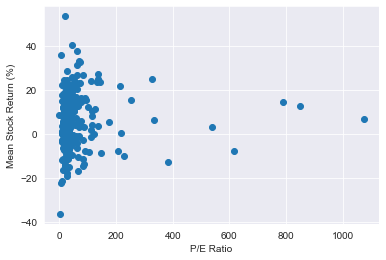

In [54]:
df_2021_Q1 = df_cleaned[(df_cleaned.year == 2021) & (df_cleaned.quarter == 1)]
plt.scatter(df_2021_Q1['pe_ratio'], df_2021_Q1['return_3m'])
plt.xlabel('P/E Ratio')
plt.ylabel('Mean Stock Return (%)')
plt.show()

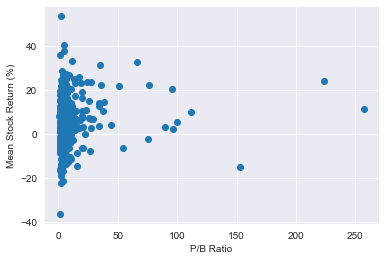

In [55]:
plt.scatter(df_2021_Q1['pb_ratio'], df_2021_Q1['return_3m'])
plt.xlabel('P/B Ratio')
plt.ylabel('Mean Stock Return (%)')
plt.show()

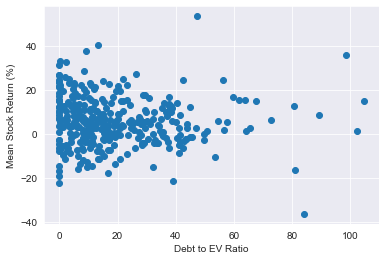

In [56]:
plt.scatter(df_2021_Q1['debt_to_ev_ratio'], df_2021_Q1['return_3m'])
plt.xlabel('Debt to EV Ratio')
plt.ylabel('Mean Stock Return (%)')
plt.show()

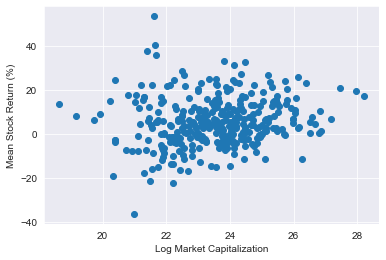

In [57]:
plt.scatter(np.log(df_2021_Q1['market_cap']), df_2021_Q1['return_3m'])
plt.xlabel('Log Market Capitalization')
plt.ylabel('Mean Stock Return (%)')
plt.show()

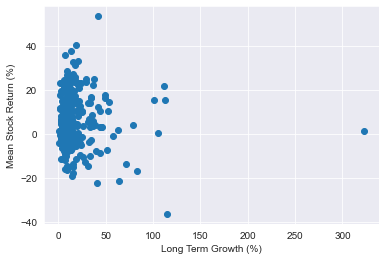

In [58]:
plt.scatter(df_2021_Q1['long_term_growth'], df_2021_Q1['return_3m'])
plt.xlabel('Long Term Growth (%)')
plt.ylabel('Mean Stock Return (%)')
plt.show()

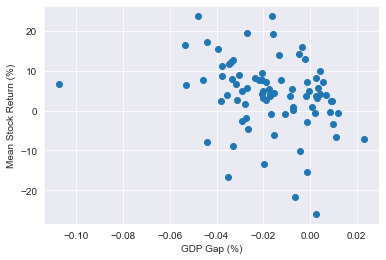

In [59]:
plt.scatter(df_time_series['gdp_gap'], df_time_series['return_3m'])
plt.xlabel('GDP Gap (%)')
plt.ylabel('Mean Stock Return (%)')
plt.show()

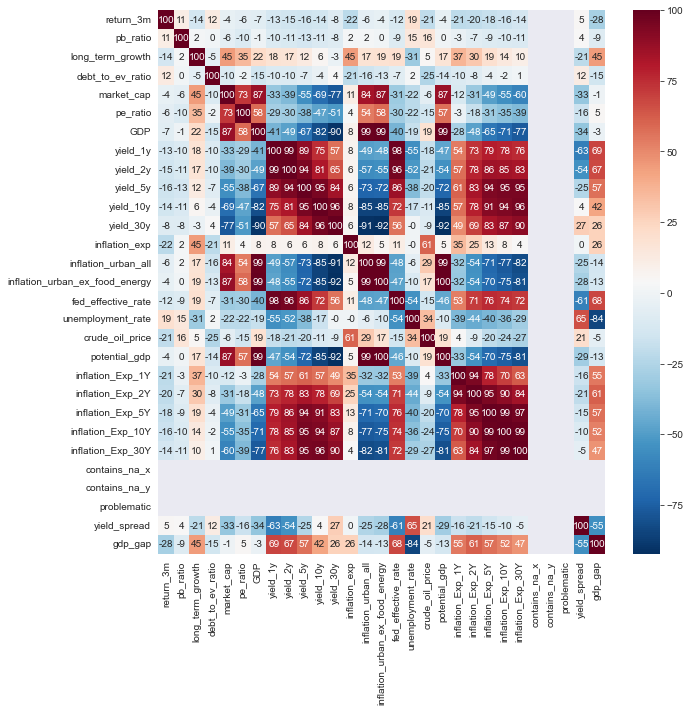

In [60]:
correlations = df_time_series.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(correlations*100, annot = True, fmt = '.0f', cmap = 'RdBu_r')
plt.show()

In [61]:
df_cleaned.head()

,stock,return_3m,year,quarter,pb_ratio,long_term_growth,debt_to_ev_ratio,market_cap,pe_ratio,GDP,yield_1y,yield_2y,yield_5y,yield_10y,yield_30y,inflation_exp,inflation_urban_all,inflation_urban_ex_food_energy,fed_effective_rate,unemployment_rate,crude_oil_price,potential_gdp,inflation_Exp_1Y,inflation_Exp_2Y,inflation_Exp_5Y,inflation_Exp_10Y,inflation_Exp_30Y,contains_na_x,contains_na_y,problematic,yield_spread,gdp_gap
0,AA,-13.822526,2018.0,2.0,1.628362,11.30,13.089416,8.741050e+09,35.610112,20492.492,2.33,2.52,2.73,2.85,2.98,3.0,251.118,257.449,1.91,4.0,67.87,20503.32000,1.590995,1.772140,1.924010,2.045903,2.310123,False,0,False,0.33,-0.000528
1,AA,-34.207921,2018.0,3.0,1.499505,4.50,18.446072,7.533511e+09,41.815020,20659.102,2.59,2.81,2.94,3.05,3.19,2.7,252.239,258.505,2.18,3.7,70.23,20682.68000,2.410015,2.206002,2.103109,2.136153,2.340414,False,0,False,0.24,-0.001140
2,AA,5.944319,2018.0,4.0,0.950347,4.00,23.300936,4.957012e+09,80.638311,20813.325,2.63,2.48,2.51,2.69,3.02,2.7,252.551,259.934,2.40,3.9,49.52,20881.05000,1.981070,1.995989,2.019533,2.091349,2.323323,False,0,False,0.21,-0.003243
3,AAL.O,-25.395774,2015.0,1.0,18.215095,23.20,37.980535,3.676918e+10,13.417155,17991.348,0.26,0.56,1.37,1.94,2.54,3.0,235.976,240.755,0.06,5.4,47.82,18297.43359,0.798439,1.190572,1.495196,1.703487,2.115891,False,0,False,1.38,-0.016728
4,AAL.O,-2.536477,2015.0,2.0,10.024215,20.05,50.932689,2.766692e+10,8.717757,18193.707,0.28,0.64,1.63,2.35,3.11,2.7,237.657,242.064,0.08,5.3,59.82,18481.76535,1.775055,1.695114,1.711298,1.824036,2.164157,False,0,False,1.71,-0.015586


In [62]:
df_cleaned['is_inversion'] = (df_cleaned['yield_spread'] < 0).astype(int)

In [63]:
df_cleaned['log_market_cap'] = np.log(df_cleaned['market_cap'])

In [64]:
micro_var = ['pe_ratio', 'pb_ratio', 'market_cap', 'debt_to_ev_ratio']
for var in micro_var:
    new_var_name1 = var + "_gdp_gap"
    df_cleaned[new_var_name1] = df_cleaned[var]*df_cleaned["gdp_gap"]
    new_var_name2 = var + "_yield_spread"
    df_cleaned[new_var_name2] = df_cleaned[var]*df_cleaned["yield_spread"]
    new_var_name3 = var + "_is_inversion"
    df_cleaned[new_var_name3] = df_cleaned[var]*df_cleaned["yield_spread"]

In [65]:
df_abt = df_cleaned.drop(['market_cap', 'GDP', 'potential_gdp'], axis = 1)

In [66]:
df_abt.head()

,stock,return_3m,year,quarter,pb_ratio,long_term_growth,debt_to_ev_ratio,pe_ratio,yield_1y,yield_2y,yield_5y,yield_10y,yield_30y,inflation_exp,inflation_urban_all,inflation_urban_ex_food_energy,fed_effective_rate,unemployment_rate,crude_oil_price,inflation_Exp_1Y,inflation_Exp_2Y,inflation_Exp_5Y,inflation_Exp_10Y,inflation_Exp_30Y,contains_na_x,contains_na_y,problematic,yield_spread,gdp_gap,is_inversion,log_market_cap,pe_ratio_gdp_gap,pe_ratio_yield_spread,pe_ratio_is_inversion,pb_ratio_gdp_gap,pb_ratio_yield_spread,pb_ratio_is_inversion,market_cap_gdp_gap,market_cap_yield_spread,market_cap_is_inversion,debt_to_ev_ratio_gdp_gap,debt_to_ev_ratio_yield_spread,debt_to_ev_ratio_is_inversion
0,AA,-13.822526,2018.0,2.0,1.628362,11.30,13.089416,35.610112,2.33,2.52,2.73,2.85,2.98,3.0,251.118,257.449,1.91,4.0,67.87,1.590995,1.772140,1.924010,2.045903,2.310123,False,0,False,0.33,-0.000528,0,22.891296,-0.018806,11.751337,11.751337,-0.000860,0.537360,0.537360,-4.616232e+06,2.884546e+09,2.884546e+09,-0.006913,4.319507,4.319507
1,AA,-34.207921,2018.0,3.0,1.499505,4.50,18.446072,41.815020,2.59,2.81,2.94,3.05,3.19,2.7,252.239,258.505,2.18,3.7,70.23,2.410015,2.206002,2.103109,2.136153,2.340414,False,0,False,0.24,-0.001140,0,22.742627,-0.047669,10.035605,10.035605,-0.001709,0.359881,0.359881,-8.588109e+06,1.808043e+09,1.808043e+09,-0.021028,4.427057,4.427057
2,AA,5.944319,2018.0,4.0,0.950347,4.00,23.300936,80.638311,2.63,2.48,2.51,2.69,3.02,2.7,252.551,259.934,2.40,3.9,49.52,1.981070,1.995989,2.019533,2.091349,2.323323,False,0,False,0.21,-0.003243,0,22.324069,-0.261540,16.934045,16.934045,-0.003082,0.199573,0.199573,-1.607743e+07,1.040972e+09,1.040972e+09,-0.075574,4.893196,4.893196
3,AAL.O,-25.395774,2015.0,1.0,18.215095,23.20,37.980535,13.417155,0.26,0.56,1.37,1.94,2.54,3.0,235.976,240.755,0.06,5.4,47.82,0.798439,1.190572,1.495196,1.703487,2.115891,False,0,False,1.38,-0.016728,0,24.327926,-0.224447,18.515673,18.515673,-0.304708,25.136831,25.136831,-6.150871e+08,5.074147e+10,5.074147e+10,-0.635351,52.413138,52.413138
4,AAL.O,-2.536477,2015.0,2.0,10.024215,20.05,50.932689,8.717757,0.28,0.64,1.63,2.35,3.11,2.7,237.657,242.064,0.08,5.3,59.82,1.775055,1.695114,1.711298,1.824036,2.164157,False,0,False,1.71,-0.015586,0,24.043503,-0.135876,14.907365,14.907365,-0.156238,17.141407,17.141407,-4.312190e+08,4.731044e+10,4.731044e+10,-0.793841,87.094898,87.094898


In [67]:
print(df_abt.is_inversion.mean())

0.05249241014592106


About 5% of observations correspond to periods with inversions in the yield curve. 

In [68]:
df_abt['yq'] = (df_abt['year']*10+df_abt['quarter']).astype(int)
df_abt.head()

,stock,return_3m,year,quarter,pb_ratio,long_term_growth,debt_to_ev_ratio,pe_ratio,yield_1y,yield_2y,yield_5y,yield_10y,yield_30y,inflation_exp,inflation_urban_all,inflation_urban_ex_food_energy,fed_effective_rate,unemployment_rate,crude_oil_price,inflation_Exp_1Y,inflation_Exp_2Y,inflation_Exp_5Y,inflation_Exp_10Y,inflation_Exp_30Y,contains_na_x,contains_na_y,problematic,yield_spread,gdp_gap,is_inversion,log_market_cap,pe_ratio_gdp_gap,pe_ratio_yield_spread,pe_ratio_is_inversion,pb_ratio_gdp_gap,pb_ratio_yield_spread,pb_ratio_is_inversion,market_cap_gdp_gap,market_cap_yield_spread,market_cap_is_inversion,debt_to_ev_ratio_gdp_gap,debt_to_ev_ratio_yield_spread,debt_to_ev_ratio_is_inversion,yq
0,AA,-13.822526,2018.0,2.0,1.628362,11.30,13.089416,35.610112,2.33,2.52,2.73,2.85,2.98,3.0,251.118,257.449,1.91,4.0,67.87,1.590995,1.772140,1.924010,2.045903,2.310123,False,0,False,0.33,-0.000528,0,22.891296,-0.018806,11.751337,11.751337,-0.000860,0.537360,0.537360,-4.616232e+06,2.884546e+09,2.884546e+09,-0.006913,4.319507,4.319507,20182
1,AA,-34.207921,2018.0,3.0,1.499505,4.50,18.446072,41.815020,2.59,2.81,2.94,3.05,3.19,2.7,252.239,258.505,2.18,3.7,70.23,2.410015,2.206002,2.103109,2.136153,2.340414,False,0,False,0.24,-0.001140,0,22.742627,-0.047669,10.035605,10.035605,-0.001709,0.359881,0.359881,-8.588109e+06,1.808043e+09,1.808043e+09,-0.021028,4.427057,4.427057,20183
2,AA,5.944319,2018.0,4.0,0.950347,4.00,23.300936,80.638311,2.63,2.48,2.51,2.69,3.02,2.7,252.551,259.934,2.40,3.9,49.52,1.981070,1.995989,2.019533,2.091349,2.323323,False,0,False,0.21,-0.003243,0,22.324069,-0.261540,16.934045,16.934045,-0.003082,0.199573,0.199573,-1.607743e+07,1.040972e+09,1.040972e+09,-0.075574,4.893196,4.893196,20184
3,AAL.O,-25.395774,2015.0,1.0,18.215095,23.20,37.980535,13.417155,0.26,0.56,1.37,1.94,2.54,3.0,235.976,240.755,0.06,5.4,47.82,0.798439,1.190572,1.495196,1.703487,2.115891,False,0,False,1.38,-0.016728,0,24.327926,-0.224447,18.515673,18.515673,-0.304708,25.136831,25.136831,-6.150871e+08,5.074147e+10,5.074147e+10,-0.635351,52.413138,52.413138,20151
4,AAL.O,-2.536477,2015.0,2.0,10.024215,20.05,50.932689,8.717757,0.28,0.64,1.63,2.35,3.11,2.7,237.657,242.064,0.08,5.3,59.82,1.775055,1.695114,1.711298,1.824036,2.164157,False,0,False,1.71,-0.015586,0,24.043503,-0.135876,14.907365,14.907365,-0.156238,17.141407,17.141407,-4.312190e+08,4.731044e+10,4.731044e+10,-0.793841,87.094898,87.094898,20152


In [69]:
df_abt = df_abt.drop(['year', 'quarter'], axis = 1)

In [70]:
df_abt.to_csv('analytical_base_table.csv', index = None)

## Algorithm Selection 

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import GroupKFold

In [94]:
df_abt = pd.read_csv('analytical_base_table.csv')
df_abt.yq.unique()

array([20182, 20183, 20184, 20151, 20152, 20153, 20154, 20171, 20172,
       20173, 20174, 20194, 20013, 20022, 20031, 20032, 20033, 20041,
       20042, 20043, 20044, 20052, 20062, 20071, 20072, 20081, 20082,
       20083, 20084, 20091, 20092, 20093, 20113, 20124, 20023, 20024,
       20034, 20051, 20053, 20054, 20061, 20063, 20064, 20073, 20074,
       20094, 20101, 20102, 20103, 20104, 20111, 20112, 20114, 20121,
       20122, 20123, 20132, 20133, 20134, 20141, 20142, 20143, 20144,
       20161, 20162, 20163, 20164, 20191, 20192, 20193, 20201, 20202,
       20203, 20211, 20212, 20213, 20214, 20204, 20014, 20011, 20012],
      dtype=int64)

In [95]:
past_return = df_abt[["return_3m", "yq", "stock"]]
past_return["yq"] = past_return["yq"] + 1

C:\Users\rohhe\AppData\Local\Temp\ipykernel_2144\1402513321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_return["yq"] = past_return["yq"] + 1


In [96]:
past_return.loc[past_return.yq%10 == 5, "yq"] = past_return.loc[past_return.yq%10 == 5, "yq"] + 6

In [97]:
past_return.yq.unique()

array([20183, 20184, 20191, 20152, 20153, 20154, 20161, 20172, 20173,
       20174, 20181, 20201, 20014, 20023, 20032, 20033, 20034, 20042,
       20043, 20044, 20051, 20053, 20063, 20072, 20073, 20082, 20083,
       20084, 20091, 20092, 20093, 20094, 20114, 20131, 20024, 20031,
       20041, 20052, 20054, 20061, 20062, 20064, 20071, 20074, 20081,
       20101, 20102, 20103, 20104, 20111, 20112, 20113, 20121, 20122,
       20123, 20124, 20133, 20134, 20141, 20142, 20143, 20144, 20151,
       20162, 20163, 20164, 20171, 20192, 20193, 20194, 20202, 20203,
       20204, 20212, 20213, 20214, 20221, 20211, 20021, 20012, 20013],
      dtype=int64)

In [98]:
past_return = past_return.rename(columns = {"return_3m": "past_return"})

In [99]:
df_abt = pd.merge(df_abt, past_return, on = ["stock", "yq"])

In [100]:
df_abt.head()

,stock,return_3m,pb_ratio,long_term_growth,debt_to_ev_ratio,pe_ratio,yield_1y,yield_2y,yield_5y,yield_10y,yield_30y,inflation_exp,inflation_urban_all,inflation_urban_ex_food_energy,fed_effective_rate,unemployment_rate,crude_oil_price,inflation_Exp_1Y,inflation_Exp_2Y,inflation_Exp_5Y,inflation_Exp_10Y,inflation_Exp_30Y,contains_na_x,contains_na_y,problematic,yield_spread,gdp_gap,is_inversion,log_market_cap,pe_ratio_gdp_gap,pe_ratio_yield_spread,pe_ratio_is_inversion,pb_ratio_gdp_gap,pb_ratio_yield_spread,pb_ratio_is_inversion,market_cap_gdp_gap,market_cap_yield_spread,market_cap_is_inversion,debt_to_ev_ratio_gdp_gap,debt_to_ev_ratio_yield_spread,debt_to_ev_ratio_is_inversion,yq,past_return
0,AA,-34.207921,1.499505,4.50000,18.446072,41.815020,2.59,2.81,2.94,3.05,3.19,2.7,252.239,258.505,2.18,3.7,70.23,2.410015,2.206002,2.103109,2.136153,2.340414,False,0,False,0.24,-0.001140,0,22.742627,-0.047669,10.035605,10.035605,-0.001709,0.359881,0.359881,-8.588109e+06,1.808043e+09,1.808043e+09,-0.021028,4.427057,4.427057,20183,-13.822526
1,AA,5.944319,0.950347,4.00000,23.300936,80.638311,2.63,2.48,2.51,2.69,3.02,2.7,252.551,259.934,2.40,3.9,49.52,1.981070,1.995989,2.019533,2.091349,2.323323,False,0,False,0.21,-0.003243,0,22.324069,-0.261540,16.934045,16.934045,-0.003082,0.199573,0.199573,-1.607743e+07,1.040972e+09,1.040972e+09,-0.075574,4.893196,4.893196,20184,-34.207921
2,AAL.O,-2.536477,10.024215,20.05000,50.932689,8.717757,0.28,0.64,1.63,2.35,3.11,2.7,237.657,242.064,0.08,5.3,59.82,1.775055,1.695114,1.711298,1.824036,2.164157,False,0,False,1.71,-0.015586,0,24.043503,-0.135876,14.907365,14.907365,-0.156238,17.141407,17.141407,-4.312190e+08,4.731044e+10,4.731044e+10,-0.793841,87.094898,87.094898,20152,-25.395774
3,AAL.O,9.299705,7.243664,11.62567,52.535551,6.679741,0.33,0.64,1.37,2.06,2.87,2.8,237.498,243.316,0.07,5.0,45.48,1.928356,1.771112,1.740632,1.838593,2.168990,False,0,False,1.42,-0.017047,0,23.984695,-0.113868,9.485232,9.485232,-0.123481,10.286002,10.286002,-4.446966e+08,3.704325e+10,3.704325e+10,-0.895564,74.600482,74.600482,20153,-2.536477
4,AAL.O,-2.891715,7.205889,8.20700,53.782115,6.033786,0.65,1.06,1.76,2.27,3.01,2.6,237.761,244.547,0.20,5.0,37.19,1.467955,1.544266,1.665495,1.812731,2.167813,False,0,False,1.21,-0.020161,0,24.007715,-0.121645,7.300881,7.300881,-0.145275,8.719126,8.719126,-5.381741e+08,3.230009e+10,3.230009e+10,-1.084282,65.076360,65.076360,20154,9.299705


In [101]:
y = df_abt["return_3m"]
X = df_abt.drop("return_3m", axis = 1)
X = X.drop('stock', axis = 1)

In [102]:
import numpy

In [103]:
X.head()

,pb_ratio,long_term_growth,debt_to_ev_ratio,pe_ratio,yield_1y,yield_2y,yield_5y,yield_10y,yield_30y,inflation_exp,inflation_urban_all,inflation_urban_ex_food_energy,fed_effective_rate,unemployment_rate,crude_oil_price,inflation_Exp_1Y,inflation_Exp_2Y,inflation_Exp_5Y,inflation_Exp_10Y,inflation_Exp_30Y,contains_na_x,contains_na_y,problematic,yield_spread,gdp_gap,is_inversion,log_market_cap,pe_ratio_gdp_gap,pe_ratio_yield_spread,pe_ratio_is_inversion,pb_ratio_gdp_gap,pb_ratio_yield_spread,pb_ratio_is_inversion,market_cap_gdp_gap,market_cap_yield_spread,market_cap_is_inversion,debt_to_ev_ratio_gdp_gap,debt_to_ev_ratio_yield_spread,debt_to_ev_ratio_is_inversion,yq,past_return
0,1.499505,4.50000,18.446072,41.815020,2.59,2.81,2.94,3.05,3.19,2.7,252.239,258.505,2.18,3.7,70.23,2.410015,2.206002,2.103109,2.136153,2.340414,False,0,False,0.24,-0.001140,0,22.742627,-0.047669,10.035605,10.035605,-0.001709,0.359881,0.359881,-8.588109e+06,1.808043e+09,1.808043e+09,-0.021028,4.427057,4.427057,20183,-13.822526
1,0.950347,4.00000,23.300936,80.638311,2.63,2.48,2.51,2.69,3.02,2.7,252.551,259.934,2.40,3.9,49.52,1.981070,1.995989,2.019533,2.091349,2.323323,False,0,False,0.21,-0.003243,0,22.324069,-0.261540,16.934045,16.934045,-0.003082,0.199573,0.199573,-1.607743e+07,1.040972e+09,1.040972e+09,-0.075574,4.893196,4.893196,20184,-34.207921
2,10.024215,20.05000,50.932689,8.717757,0.28,0.64,1.63,2.35,3.11,2.7,237.657,242.064,0.08,5.3,59.82,1.775055,1.695114,1.711298,1.824036,2.164157,False,0,False,1.71,-0.015586,0,24.043503,-0.135876,14.907365,14.907365,-0.156238,17.141407,17.141407,-4.312190e+08,4.731044e+10,4.731044e+10,-0.793841,87.094898,87.094898,20152,-25.395774
3,7.243664,11.62567,52.535551,6.679741,0.33,0.64,1.37,2.06,2.87,2.8,237.498,243.316,0.07,5.0,45.48,1.928356,1.771112,1.740632,1.838593,2.168990,False,0,False,1.42,-0.017047,0,23.984695,-0.113868,9.485232,9.485232,-0.123481,10.286002,10.286002,-4.446966e+08,3.704325e+10,3.704325e+10,-0.895564,74.600482,74.600482,20153,-2.536477
4,7.205889,8.20700,53.782115,6.033786,0.65,1.06,1.76,2.27,3.01,2.6,237.761,244.547,0.20,5.0,37.19,1.467955,1.544266,1.665495,1.812731,2.167813,False,0,False,1.21,-0.020161,0,24.007715,-0.121645,7.300881,7.300881,-0.145275,8.719126,8.719126,-5.381741e+08,3.230009e+10,3.230009e+10,-1.084282,65.076360,65.076360,20154,9.299705


In [104]:
y = numpy.log(1+y/100.0)

In [105]:
y.head()

0   -0.418671
1    0.057743
2   -0.025692
3    0.088924
4   -0.029343
Name: return_3m, dtype: float64

In [106]:
from sklearn.model_selection import PredefinedSplit

In [107]:
X_train = X[X.yq <= 20124]
X_val = X[(X.yq > 20124) & (X.yq <= 20164)]
X_test = X[X.yq > 20164]

In [108]:
y_train = y[X.yq <= 20124]
y_val = y[(X.yq > 20124) & (X.yq <= 20164)]
y_test = y[X.yq > 20164]

In [109]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


In [110]:
print(len(X_test), len(X_val), len(X_train))

5231 4376 13819


In [111]:
X_cv = pd.concat([X_train, X_val])

In [112]:
y_cv = pd.concat([y_train, y_val])

In [113]:
ps = PredefinedSplit(np.concatenate((np.zeros(len(X_train)) - 1, np.ones(len(X_val)))))

In [114]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

13819 5231 13819 5231


In [115]:
pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet': make_pipeline(StandardScaler(), ElasticNet(random_state=123)),
    'rf': make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    'gb': make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))
}

In [116]:
lasso_hyperparameters = { 
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10] 
}
ridge_hyperparameters = { 
    'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]  
}
enet_hyperparameters = { 
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],                        
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]  
}
rf_hyperparameters = { 
    'randomforestregressor__n_estimators' : [100, 200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33],
}
gb_hyperparameters = { 
    'gradientboostingregressor__n_estimators': [100, 200],
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}

In [117]:
hyperparameters = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters
}

## Model Training

In [118]:
print(np.mean(np.concatenate((np.zeros(len(X_train)) - 1, np.ones(len(X_val))))))

-0.5189887331684528


In [119]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, param_grid = hyperparameters[name], cv=ps)
    
    # Fit model on X_train, y_train
    #model.fit(X_train, y_train, groups = group_labels )
    model.fit(X_cv, y_cv)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

lasso has been fitted.
ridge has been fitted.


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.868e+01, tolerance: 4.033e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.027e-01, tolerance: 4.033e-02
  model = cd_fast.enet_coordinate_descent(


enet has been fitted.


C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\rohhe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


rf has been fitted.
gb has been fitted.


In [120]:
for name, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print(name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


In [121]:
for name, model in fitted_models.items():
    print( name, model.best_score_ )

lasso -2.6193094402326977e-06
ridge -0.39544205417810985
enet -2.6193094402326977e-06
rf -0.07099420931381206
gb -0.031166887498281115


In [122]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

In [124]:
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print( name )
    print( '--------' )
    print( 'R^2:', r2_score(y_test, pred ))
    print( 'MAE:', median_absolute_error(y_test, pred))
    print()

lasso
--------
R^2: -0.0028725553912791746
MAE: 0.0872469070938978

ridge
--------
R^2: -0.2892444173056672
MAE: 0.12236132952270237

enet
--------
R^2: -0.0028725553912791746
MAE: 0.0872469070938978

rf
--------
R^2: -0.027120539473658445
MAE: 0.09327893538306778

gb
--------
R^2: 0.008291768246281084
MAE: 0.08617444112839241



## Identify Stocks with Abnormal Returns

In [125]:
import pickle
# Identify stocks that underperformed a lot in 2022Q1.
with open('final_model.pkl', 'rb') as f: rfmodel = pickle.load(f)
df_abt = pd.read_csv('analytical_base_table.csv')
df_2022Q1 = df_abt[df_abt.yq == 20214]
y = df_abt[["return_3m", 'stock']]
X = df_abt.drop("return_3m", axis = 1)
X = X.drop(['yq', 'stock'], axis = 1)

In [126]:
y['predicted_return'] = rfmodel.predict(X)

C:\Users\rohhe\AppData\Local\Temp\ipykernel_2144\1433858054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['predicted_return'] = rfmodel.predict(X)


In [127]:
y['deviation'] = y['return_3m'] - y['predicted_return']

C:\Users\rohhe\AppData\Local\Temp\ipykernel_2144\1879938959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['deviation'] = y['return_3m'] - y['predicted_return']


In [128]:
y = y.sort_values('deviation')

In [129]:
y[0:20]

,return_3m,stock,predicted_return,deviation
19247,-81.236090,NCLH.K,5.539702,-86.775791
18500,-75.655590,MRO,8.373906,-84.029496
23270,-75.618708,RCL,6.948246,-82.566954
14772,-79.519520,IVR,2.969066,-82.488586
5401,-73.785282,CCL,6.913466,-80.698748
20539,-75.120385,NYMT.O,3.713982,-78.834367
17023,-55.691554,LPI,22.729557,-78.421111
4224,-70.963395,BOOT.K,6.190619,-77.154014
24165,-72.605482,SABR.O,4.384391,-76.989873
7697,-75.855131,CZR.O,0.085095,-75.940226


In [130]:
y.to_csv('predicted_return_2022Q1.csv')